In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

/Users/kagarwal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
# URL of the page to scrape
url = 'https://basketball.realgm.com/international/league/1/Euroleague/players'

# Send a GET request to fetch the page content
response = requests.get(url)
page_content = response.content

In [8]:
soup = BeautifulSoup(page_content, 'html.parser')

In [9]:
# Find the table body (tbody) and all rows (tr) within it
table_body = soup.find('tbody')
rows = table_body.find_all('tr')

players = []

# Loop through each row (tr) to get player data
for row in rows:
    # Extract player data from each row
    cells = row.find_all('td')
    
    # Extract player name from the first cell (assuming it is in an <a> tag)
    name_tag = cells[0].find('a')  # Player name is assumed to be in the first cell inside <a> tag
    if name_tag:
        player_name = name_tag.get_text(strip=True)
    else:
        player_name = "Unknown"  # Default if name is missing
    
    # Extract height from the third column (height)
    height = cells[2].get_text(strip=True)
    
    # Extract weight from the fourth column (weight)
    weight = cells[3].get_text(strip=True)

    # Store the player information
    players.append({
        'name': player_name,
        'height': height,
        'weight': weight
    })

# Print the scraped player data
# for i in range(0,10):
#     for player in players:
#         print(player)

In [19]:
# URL of the page to scrape for Player Stats
url = 'https://basketball.realgm.com/international/league/1/Euroleague/stats'

# Send a GET request to fetch the page content
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
page_content = response.content

In [11]:
# Grab the first stats table on the page (this is the main stats table)
table = soup.find('table')
if not table:
    raise Exception("Table not found on the page.")

# Get the table headers
thead = table.find('thead')
header_cells = thead.find_all('th')
column_names = [cell.get_text(strip=True) for cell in header_cells]

# Extract player rows
tbody = table.find('tbody')
rows = tbody.find_all('tr')

player_stats = []

for row in rows:
    cells = row.find_all('td')
    if len(cells) != len(column_names):
        continue  # skip rows that don't match

    player_data = {}
    for i, cell in enumerate(cells):
        if i == 0:
            # Extract name from <a> tag if available
            link = cell.find('a')
            player_data[column_names[i]] = link.get_text(strip=True) if link else cell.get_text(strip=True)
        else:
            player_data[column_names[i]] = cell.get_text(strip=True)
    player_stats.append(player_data)

# Print each player's stats
# for player in player_stats:
#     print(player)


In [12]:
# Convert height/weight data to a dictionary for faster lookup
height_weight_map = {player['name']: {'height': player['height'], 'weight': player['weight']} for player in players}

# Merge height and weight into the player_stats list
for stat in player_stats:
    name = stat['Player']
    if name in height_weight_map:
        stat['Height'] = height_weight_map[name]['height']
        stat['Weight'] = height_weight_map[name]['weight']
    else:
        stat['Height'] = 'N/A'
        stat['Weight'] = 'N/A'

# Optionally: create a DataFrame and export to CSV (ONLY TO TEST IT)
# df = pd.DataFrame(player_stats)
# df.to_csv('euroleague_player_stats_with_height_weight.csv', index=False)

# Or just print the merged data
# for player in player_stats:
#     print(player)


In [13]:
all_stats = []

for year in range(2024, 1999, -1):
    url = f'https://basketball.realgm.com/international/league/1/Euroleague/stats/{year}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    table = soup.find('table')
    if not table:
        continue

    thead = table.find('thead')
    header_cells = thead.find_all('th')
    column_names = [cell.get_text(strip=True) for cell in header_cells]

    tbody = table.find('tbody')
    rows = tbody.find_all('tr')

    for row in rows:
        cells = row.find_all('td')
        if len(cells) != len(column_names):
            continue

        player_data = {'Season': year}
        for i, cell in enumerate(cells):
            text = cell.get_text(strip=True)
            if i == 0:
                link = cell.find('a')
                player_data[column_names[i]] = link.get_text(strip=True) if link else text
            else:
                player_data[column_names[i]] = text

        all_stats.append(player_data)


In [15]:
# Convert height/weight data to a dictionary for faster lookup
height_weight_map = {player['name']: {'height': player['height'], 'weight': player['weight']} for player in players}

# Merge height and weight into the all_stats list
for stat in all_stats:
    name = stat['Player']
    if name in height_weight_map:
        stat['Height'] = height_weight_map[name]['height']
        stat['Weight'] = height_weight_map[name]['weight']
    else:
        stat['Height'] = 'N/A'
        stat['Weight'] = 'N/A'

# Convert the combined data to a DataFrame
df = pd.DataFrame(all_stats)

# Drop any row with N/A values
df = df[~df.isin(['N/A']).any(axis=1)]

# Save the combined data to a CSV file
df.to_csv('latest_euroleague_player_stats_with_height_weight.csv', index=False)

# Optionally, print the DataFrame
# print(df)


In [16]:
# load output csv into dataframe
df = pd.read_csv("latest_euroleague_player_stats_with_height_weight.csv")
print(df.shape)
print(df.head())

# drop unnecessary columns
df = df.drop(columns=['Season', '#', 'Player', 'Team'])

# convert height to easier format
def height_to_inches(height_str):
    if isinstance(height_str, str) and '-' in height_str:
        feet, inches = map(int, height_str.split('-'))
        return feet * 12 + inches
    return height_str

df['Height'] = df['Height'].apply(height_to_inches)
print(df.shape)
print(df.head())

(836, 26)
   Season  #           Player  Team  GP   MPG   PPG  FGM   FGA    FG%  ...  \
0    2024  1    Markus Howard  BASK  39  23.0  19.5  6.5  15.1  0.431  ...   
1    2024  2       Mike James   ASM  39  31.7  17.9  5.9  13.9  0.426  ...   
2    2024  3  Wade Baldwin IV   MAC  30  27.6  17.4  5.7  12.4  0.456  ...   
3    2024  4     Keenan Evans   ZAL  34  27.4  17.3  5.5  11.5  0.481  ...   
4    2024  5   Nikola Mirotic   MIL  21  26.5  16.9  5.4  10.2  0.526  ...   

   ORB  DRB  RPG  APG  SPG  BPG  TOV   PF  Height  Weight  
0  0.3  0.9  1.2  1.6  0.5  0.0  1.9  2.7    5-11     180  
1  0.5  3.6  4.1  5.1  1.2  0.1  2.1  1.8     6-1     190  
2  0.3  2.2  2.5  4.9  1.0  0.2  2.6  1.9     6-4     220  
3  0.5  2.3  2.8  3.9  1.2  0.1  2.3  2.4     6-3     190  
4  1.8  3.9  5.7  0.9  0.8  0.3  1.7  2.2    6-10     250  

[5 rows x 26 columns]
(836, 22)
   GP   MPG   PPG  FGM   FGA    FG%  3PM  3PA    3P%  FTM  ...  ORB  DRB  RPG  \
0  39  23.0  19.5  6.5  15.1  0.431  3.8  9.5  

In [17]:
# for the model
data_characteristics = {} 
# each entry will have this format -
#   "feature_name": {"mean":<num>,"stddev":<num>,"median":<num>,"iqr":<num>}

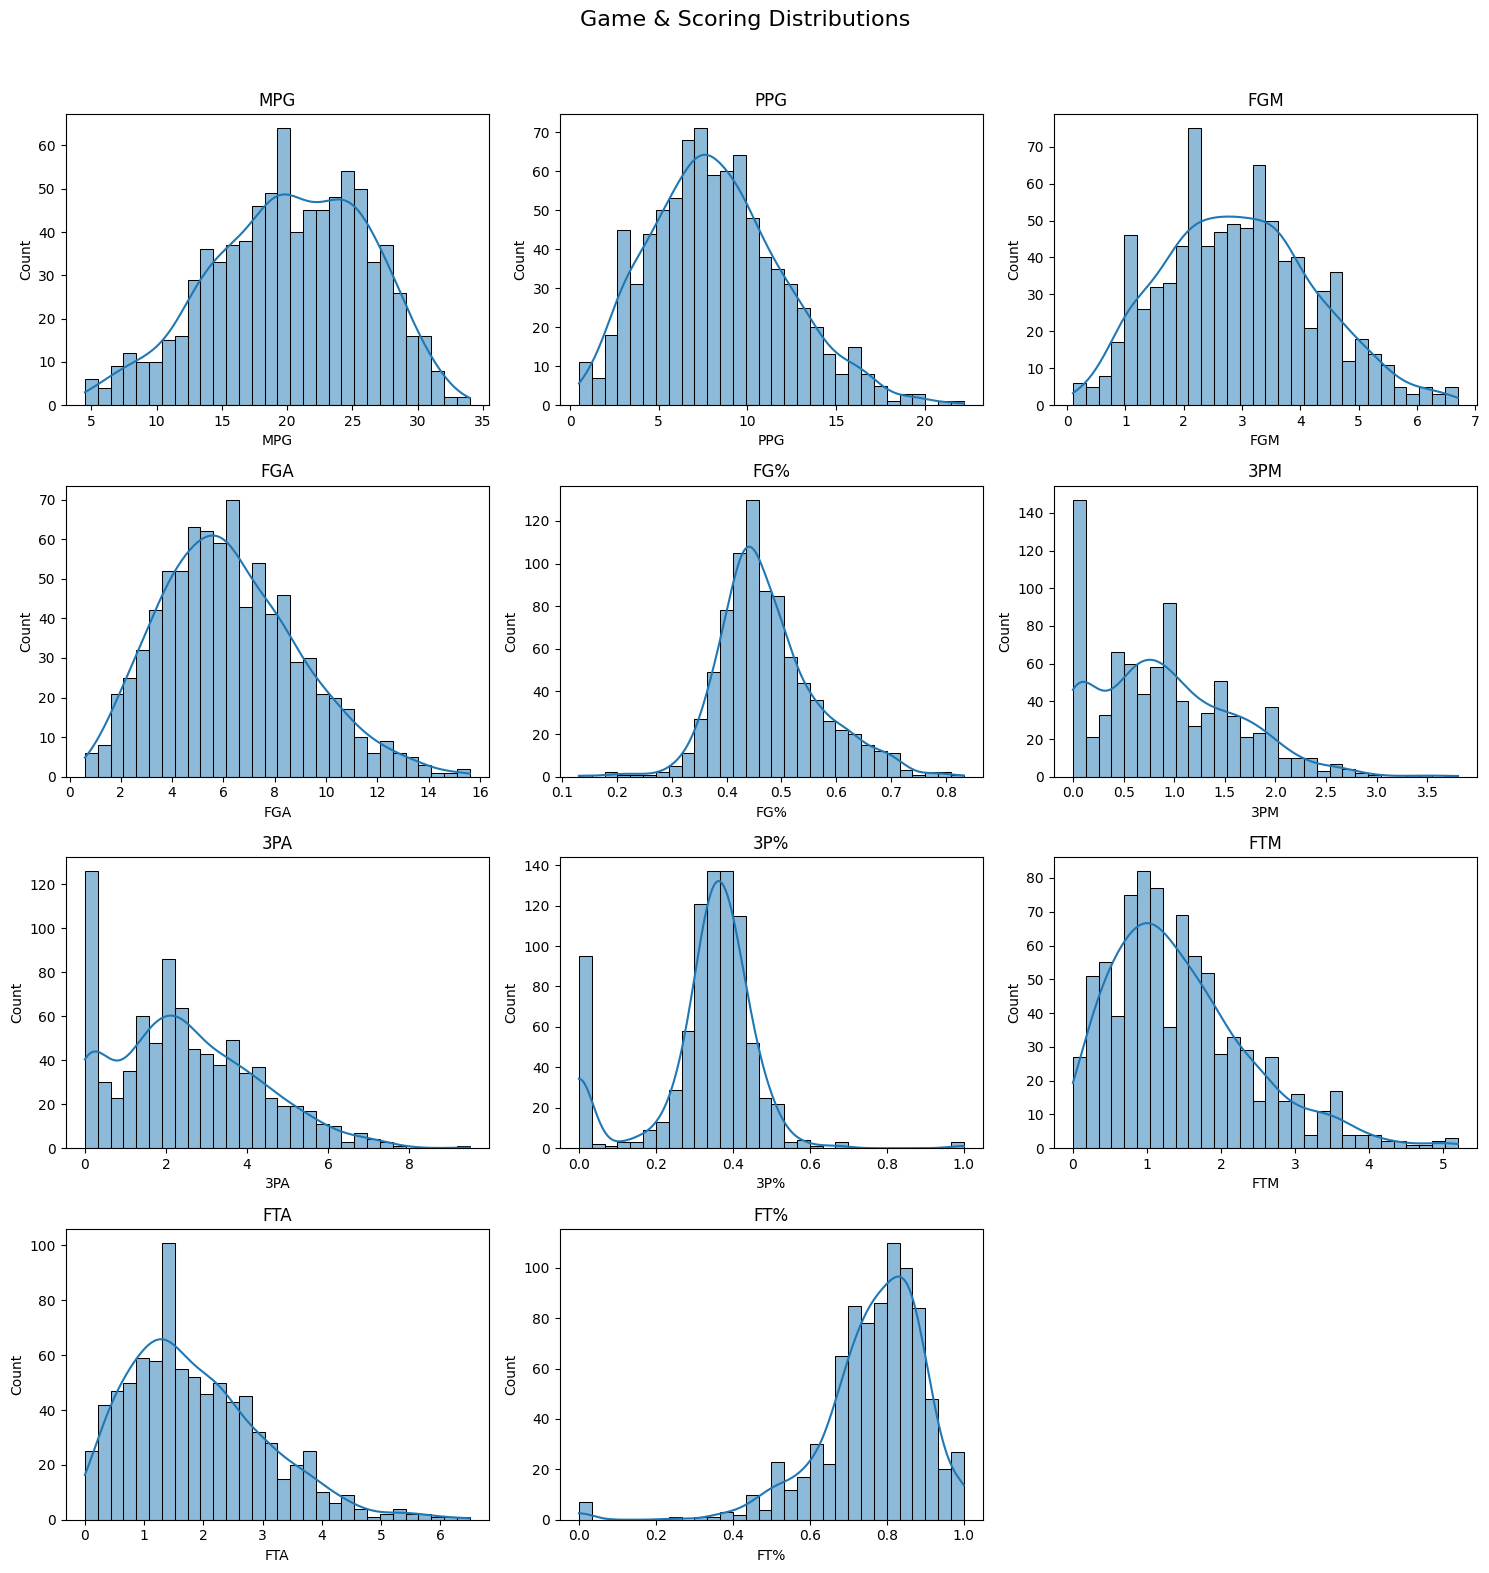

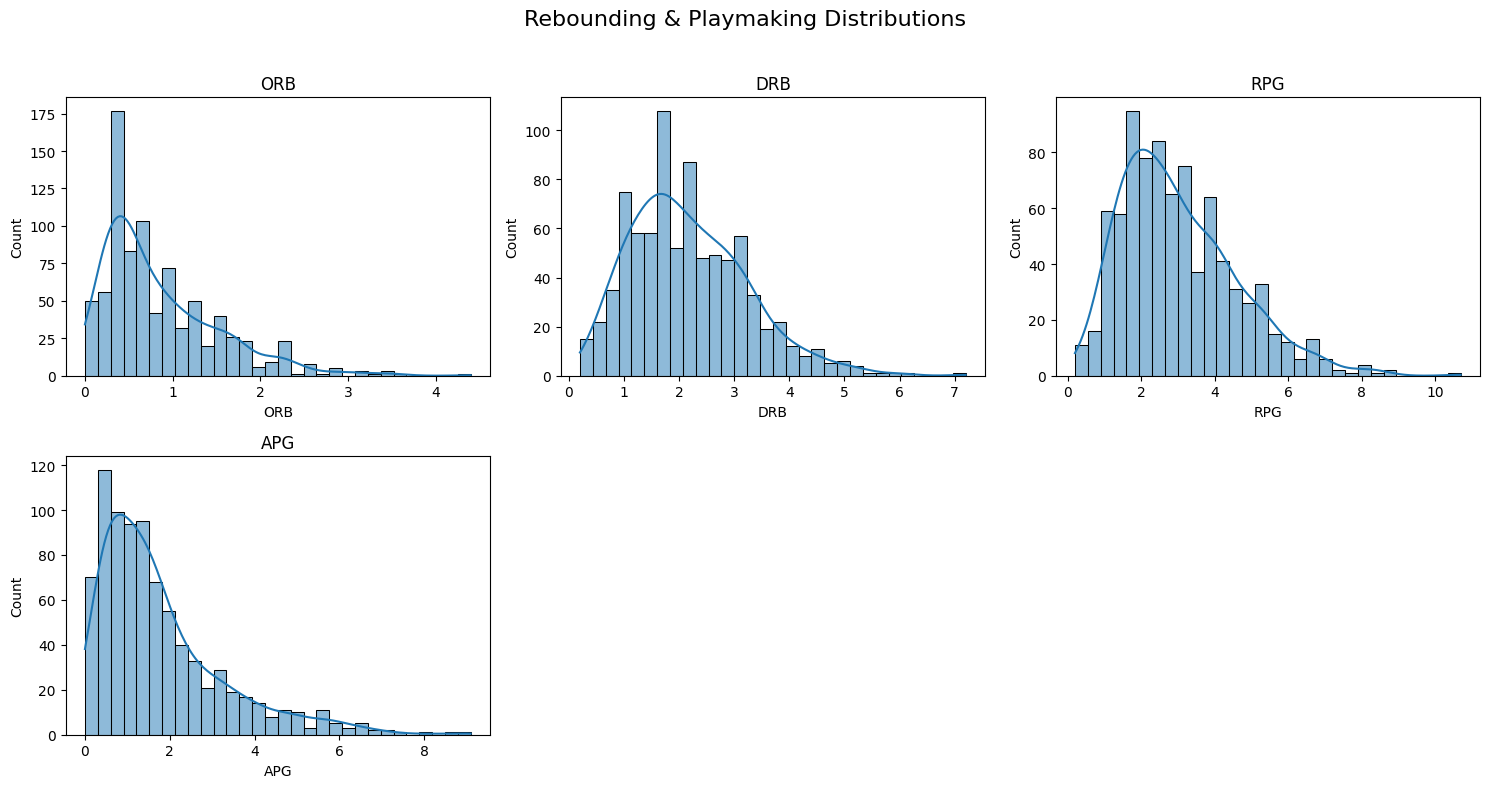

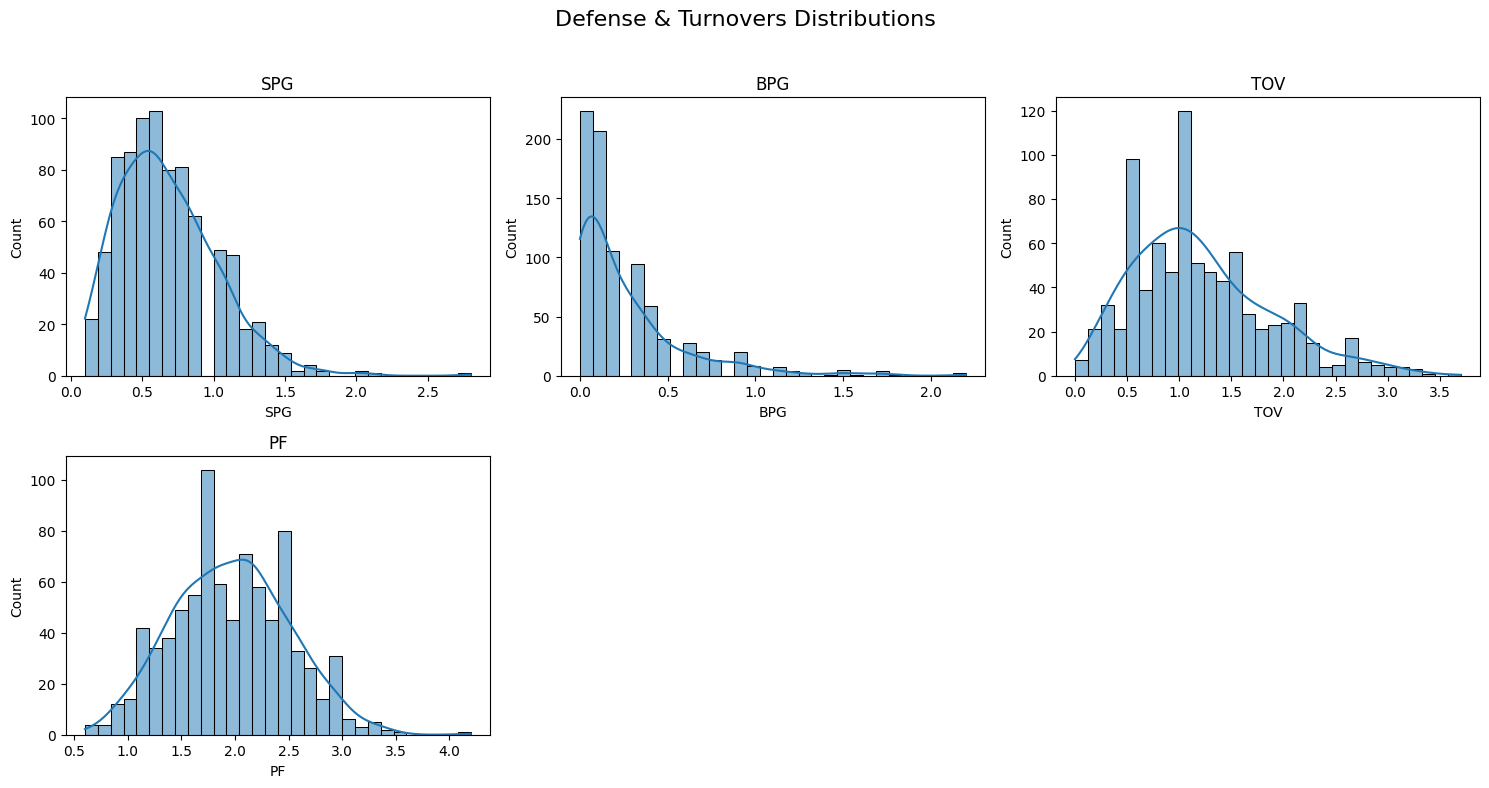

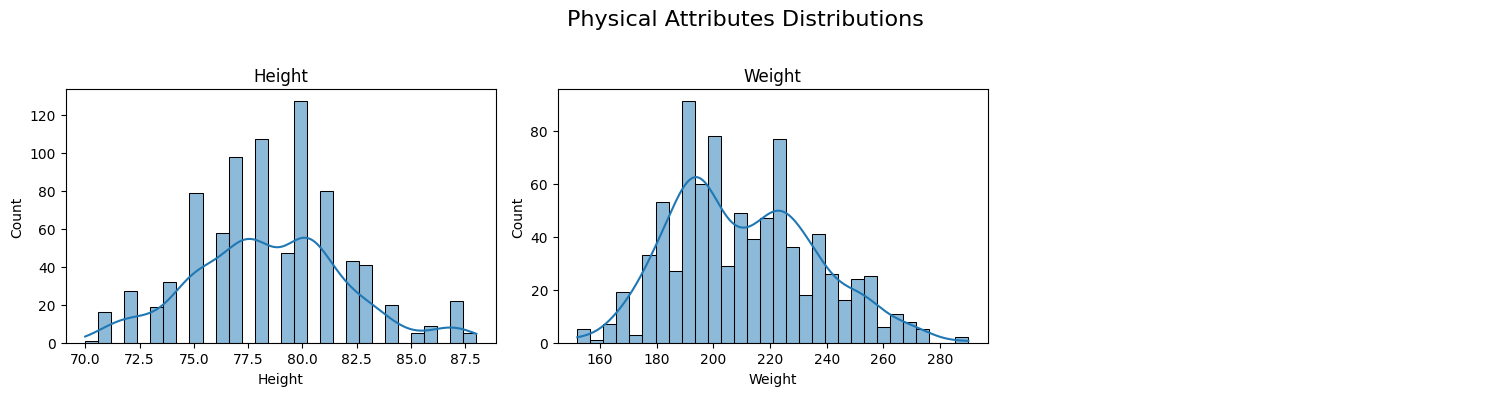

{'MPG': {'mean': np.float64(20.2122009569378), 'stddev': np.float64(5.933858551202222), 'median': np.float64(20.35), 'iqr': np.float64(8.9)}, 'PPG': {'mean': np.float64(8.301435406698564), 'stddev': np.float64(3.7632350520397413), 'median': np.float64(8.0), 'iqr': np.float64(5.0)}, 'FGM': {'mean': np.float64(2.9633971291866024), 'stddev': np.float64(1.2939009171559073), 'median': np.float64(2.9), 'iqr': np.float64(1.7999999999999998)}, 'FGA': {'mean': np.float64(6.258851674641148), 'stddev': np.float64(2.726864466286177), 'median': np.float64(6.0), 'iqr': np.float64(3.8)}, 'FG%': {'mean': np.float64(0.4764653110047847), 'stddev': np.float64(0.09059350543151659), 'median': np.float64(0.46), 'iqr': np.float64(0.10425000000000001)}, '3PM': {'mean': np.float64(0.9165071770334928), 'stddev': np.float64(0.6864228205495378), 'median': np.float64(0.8), 'iqr': np.float64(0.9999999999999999)}, '3PA': {'mean': np.float64(2.481818181818182), 'stddev': np.float64(1.7581780295718137), 'median': np.f

In [18]:
# plot attributes

import matplotlib.pyplot as plt
import seaborn as sns

groups = {
    "Game & Scoring": ['MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%'],
    "Rebounding & Playmaking": ['ORB', 'DRB', 'RPG', 'APG'],
    "Defense & Turnovers": ['SPG', 'BPG', 'TOV', 'PF'],
    "Physical Attributes": ['Height', 'Weight']
}

# plot each group in a grid
for group_name, features in groups.items():
    n_cols = 3
    n_rows = (len(features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle(f'{group_name} Distributions', fontsize=16)
    axes = axes.flatten()

    for i, col in enumerate(features):
        # make plot
        sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
        axes[i].set_title(col)

        # save mean, stddev, median, IQR of feature
        data_characteristics[col] = {
            "mean": df[col].mean(), 
            "stddev": df[col].std(), 
            "median": df[col].median(), 
            "iqr": df[col].quantile(0.75)-df[col].quantile(0.25)
        }

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# for feature, characteristics in data_characteristics:
    # print(feature, ":", characteristics)
print(data_characteristics)

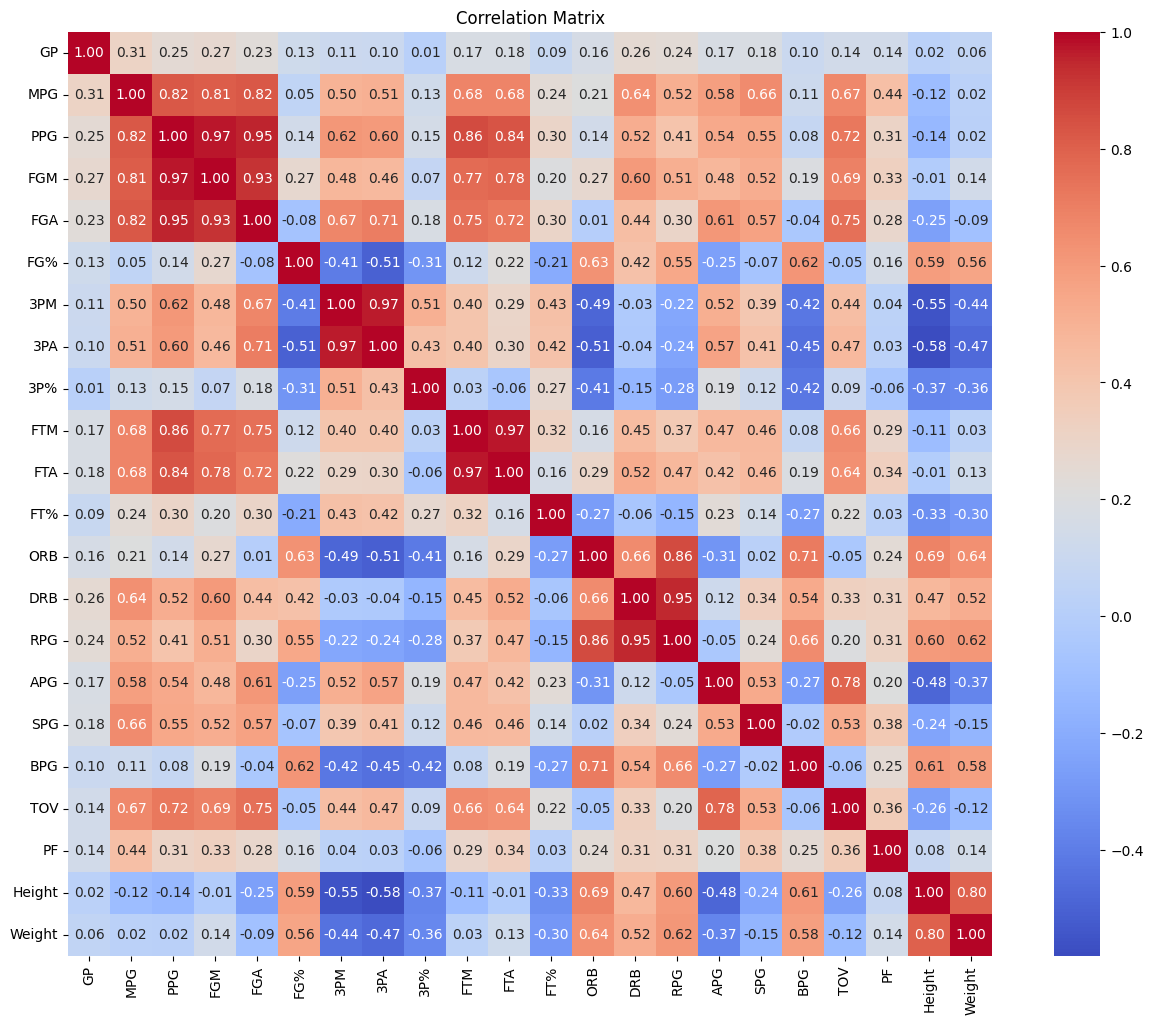

In [19]:
plt.figure(figsize=(16, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

In [20]:
import pandas as pd

# Example weights between 0 and 1 for feature importance
weights = {
    'MPG': 0.3,     # Small signal of coach trust, not much for 1v1
    'PPG': 1.0,     # Strongest weight – scoring is everything
    'FGM': 0.8,     # Volume scoring
    'FGA': 0.6,     # Volume attempts – shows aggressiveness
    'FG%': 0.9,     # Efficient shooting is key
    '3PM': 0.7,     # Making threes gives space
    '3PA': 0.5,     # Attempts show range
    '3P%': 0.8,     # Accuracy from 3 is crucial
    'FTM': 0.1,     # Barely matters
    'FTA': 0.1,     # Same
    'FT%': 0.2,     # Same
    'ORB': 0.4,     # Second chances
    'DRB': 0.4,     # Defensive control
    'RPG': 0.5,     # Overall rebounding ability
    'APG': 0.3,     # Passing not supefr relevant in 1v1, but can indicate ball-handling ability, IQ
    'SPG': 0.6,     # Shows defensive instincts
    'BPG': 0.7,     # Rim protection matters in 1v1
    'TOV': 0.1,     # Not very useful, but a very turnover-prone player might be exposed
    'PF': 0.0,      # Not used in 1v1
    'Height': 0.8,  # Major advantage in post or defense
    'Weight': 0.6   # Strength helps to hold position or bully
}


scaled_features = {}

for feature, w in weights.items():
    # Get mean and stddev from the data_characteristics dictionary (created by Melody)
    mean = data_characteristics[feature]['mean']
    stddev = data_characteristics[feature]['stddev']

    # Avoid division by zero if stddev is zero (rare but possible)
    if stddev == 0:
        print(f"Warning: stddev for {feature} is zero, skipping scaling.")
        scaled = df[feature] * 0  # all zeros (no variation)
    else:
        # Calculate Z-score using precomputed mean and stddev
        z_score = (df[feature] - mean) / stddev

        # Multiply by weight to scale influence (0 to 1)
        scaled = z_score * w

    # Store the scaled feature with suffix '_scaled'
    scaled_features[f"{feature}_scaled"] = scaled

# Create a DataFrame of all players using containing all scaled features
df_scaled = pd.DataFrame(scaled_features)

# Optional: inspect the first few rows of the scaled data
print(df_scaled.head())
print(data_characteristics['MPG']['mean'])
print(data_characteristics['MPG']['stddev'])

   MPG_scaled  PPG_scaled  FGM_scaled  FGA_scaled  FG%_scaled  3PM_scaled  \
0    0.140944    2.975781    2.186630    1.945344   -0.451675    2.940527   
1    0.580792    2.550615    1.815659    1.681304   -0.501347    1.308880   
2    0.373507    2.417751    1.692002    1.351255   -0.203312    0.493056   
3    0.363396    2.391178    1.568344    1.153225    0.045050    1.512836   
4    0.317894    2.284886    1.506516    0.867182    0.492102    1.308880   

   3PA_scaled  3P%_scaled  FTM_scaled  FTA_scaled  ...  ORB_scaled  \
0    1.995868    0.415912    0.118920    0.115378  ...   -0.331955   
1    1.000519    0.258430    0.243999    0.262838  ...   -0.211454   
2    0.346433    0.365293    0.327386    0.314882  ...   -0.331955   
3    0.886765    0.612764    0.243999    0.202119  ...   -0.211454   
4    0.773011    0.517150    0.264846    0.245490  ...    0.571805   

   DRB_scaled  RPG_scaled  APG_scaled  SPG_scaled  BPG_scaled  TOV_scaled  \
0   -0.476286   -0.575202   -0.037516  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the EuroLeague z-scaled dataset
df_scaled = pd.read_csv('latest_euroleague_player_stats_scaled.csv')

# Now split EuroLeague into 70% training and 30% validation as that is our training data and we plan to do 70-30 splits
euroleague_train = df_scaled.sample(frac=0.7, random_state=42)
euroleague_val = df_scaled.drop(euroleague_train.index)

# Load the NBA unscaled data
nba_df = pd.read_csv('Player Totals_cleaned.csv')

# Features for our ML model
features = [
    'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%',
    'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'TOV', 'PF', 'Height', 'Weight'
]

euroleague_raw = pd.read_csv('latest_euroleague_player_stats_with_height_weight.csv')  # ← Your unscaled data
euroleague_train_raw = euroleague_raw.loc[euroleague_train.index]  # Match split by index

mean = euroleague_train_raw[features].mean()
std = euroleague_train_raw[features].std()

# Scale NBA test data using EuroLeague's mean and std
nba_scaled = (nba_df[features] - mean) / std

# Combine scaled features with player names, teams, or IDs
nba_scaled_full = nba_df.copy()
nba_scaled_full[features] = nba_scaled

# Now nba_scaled_full is your properly scaled NBA test set
print("NBA test data has been scaled using EuroLeague training statistics.")


/var/folders/bw/sw4wt20s7pj4vsll5_jghhvr0000gq/T/ipykernel_74175/1873758945.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Height'].fillna(df['Height'].median(), inplace=True)
/var/folders/bw/sw4wt20s7pj4vsll5_jghhvr0000gq/T/ipykernel_74175/1873758945.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

KeyError: 'Height'